In [1]:
#!/usr/bin/env python
import pandas as pd
import numpy as np 

# download the data from the Vanderbilt University Department of Biostatistics servers
titanic_df = pd.read_csv('http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.csv')

# save a copy to file for our web application
titanic_df.to_csv('titanic3.csv', index=False)

# take a peek at the data
titanic_df.head() 


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


<H1>Data Exploration</H1>

In [2]:
# feature data types
titanic_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
pclass       1309 non-null int64
survived     1309 non-null int64
name         1309 non-null object
sex          1309 non-null object
age          1046 non-null float64
sibsp        1309 non-null int64
parch        1309 non-null int64
ticket       1309 non-null object
fare         1308 non-null float64
cabin        295 non-null object
embarked     1307 non-null object
boat         486 non-null object
body         121 non-null float64
home.dest    745 non-null object
dtypes: float64(3), int64(4), object(7)
memory usage: 143.2+ KB


In [3]:
# summary of quantitative data
titanic_df.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881138,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413493,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


In [4]:
# count missing data
titanic_missing_count = titanic_df.isnull().sum().sort_values(ascending=False)
pd.DataFrame({'Percent Missing':titanic_missing_count/len(titanic_df)})


,Percent Missing
body,0.907563
cabin,0.774637
boat,0.628724
home.dest,0.430863
age,0.200917
embarked,0.001528
fare,0.000764
ticket,0.000000
parch,0.000000
sibsp,0.000000


In [5]:
titanic_df['cabin'].head()

0         B5
1    C22 C26
2    C22 C26
3    C22 C26
4    C22 C26
Name: cabin, dtype: object

<H1>Data Preparation</H1>

In [6]:

# create title field and get extract title name
titanic_df['title'] = [ln.split()[1] for ln in titanic_df['name'].values]
titanic_df['title'].value_counts()
titanic_df['title'] = [title if title in ['Mr.', 'Miss.', 'Mrs.', 'Master.', 'Dr.', 'Rev.'] else 'Unknown'
                       for title in titanic_df['title'].values ]

# strip first letter from cabin number if there
titanic_df['cabin'] = titanic_df['cabin'].replace(np.NaN, 'U') 
titanic_df['cabin'] = [ln[0] for ln in titanic_df['cabin'].values]
titanic_df['cabin'] = titanic_df['cabin'].replace('U', 'Unknown') 

# create isfemale field and use numerical values
titanic_df['isfemale'] = np.where(titanic_df['sex'] == 'female', 1, 0)

# drop features not needed for model 
titanic_df = titanic_df[[f for f in list(titanic_df) if f not in ['sex', 'name', 'boat','body', 'ticket', 'home.dest']]]

# make pclass actual categorical column
titanic_df['pclass'] = np.where(titanic_df['pclass'] == 1, 'First', 
                                np.where(titanic_df['pclass'] == 2, 'Second', 'Third'))


titanic_df['embarked'] = titanic_df['embarked'].replace(np.NaN, 'Unknown') 


titanic_df.head()

,pclass,survived,age,sibsp,parch,fare,cabin,embarked,title,isfemale
0,First,1,29.00,0,0,211.3375,B,S,Miss.,1
1,First,1,0.92,1,2,151.5500,C,S,Master.,0
2,First,0,2.00,1,2,151.5500,C,S,Miss.,1
3,First,0,30.00,1,2,151.5500,C,S,Mr.,0
4,First,0,25.00,1,2,151.5500,C,S,Mrs.,1


<H1>Modeling with Logistic Regression</H1>

In [7]:
# get average survival rate to compare to prediction values
average_survival_rate = np.mean(titanic_df['survived']) * 100
print('Average probability of surviving Titanic trip: %.2f percent' % average_survival_rate)


Average probability of surviving Titanic trip: 38.20 percent


In [8]:
def prepare_data_for_model(raw_dataframe):
    # dummy all categorical fields 
    dataframe_dummy = pd.get_dummies(raw_dataframe)
    # remove the nan colums in dataframe as most are outcome variable and we can't use them
    dataframe_dummy = dataframe_dummy.dropna() 
    return (dataframe_dummy)

# create dummy features 
titanic_ready_df = prepare_data_for_model(titanic_df)

In [9]:
# split data into train and test portions and model
from sklearn import cross_validation
features = [feat for feat in list(titanic_ready_df) if feat != 'survived']
X_train, X_test, y_train, y_test = cross_validation.train_test_split(titanic_ready_df[features], 
                                                 titanic_ready_df[['survived']], 
                                                 test_size=0.5, 
                                                 random_state=42)

from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train.values.ravel())


/Users/manuel/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [10]:
# predict on test portion and get accuracy score
y_pred = lr_model.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}%'
      .format(lr_model.score(X_test, y_test)*100))


Accuracy of logistic regression classifier on test set: 79.35%


<H2>Interpretation of Model’s Coefficients</H2>

In [11]:
coefs = pd.DataFrame({'Feature':features, 'Coef':lr_model.coef_[0]})
coefs.sort_values('Coef', ascending=False)

,Coef,Feature
4,1.862753,isfemale
22,1.617463,title_Master.
8,0.955168,cabin_A
25,0.947289,title_Mrs.
11,0.770702,cabin_D
17,0.733036,embarked_C
5,0.535270,pclass_First
6,0.459827,pclass_Second
12,0.456849,cabin_E
19,0.407149,embarked_S


<H2>Recursive Feature Elimination (RFE) method</H2>

In [12]:
from sklearn.feature_selection import RFE
rfe = RFE(lr_model, 1)
rfe = rfe.fit(X_train, np.ravel(y_train))

# get feature rank in order from elimination process
feature_rank = pd.DataFrame({'Feature':list(X_train),'Rank':rfe.ranking_ })
feature_rank = feature_rank.sort_values('Rank')
feature_rank.head()


,Feature,Rank
4,isfemale,1
22,title_Master.,2
16,cabin_Unknown,3
18,embarked_Q,4
6,pclass_Second,5


<H1>Predict using Fictional Passenger</H1>

In [13]:
# Create your own passenger - ranges and options available
x_predict_pclass = 'Third' # First, Second, Third
x_predict_is_female=1 # 0-1
x_predict_age=10 # 0-100
x_predict_sibsp=3 #  (0-8)
x_predict_parch = 0 #  (0-9)
x_predict_fare = 200 #  (0-500)
x_predict_cabin = 'A' # 'A', 'C', 'B', 'E', 'D', 'G', 'F', 'T', 'Z' 
x_predict_embarked = 'Q' #  'Q', 'S', 'C' # Cherbourg Queenstown Southampton
x_predict_title = 'Mrs.' # ['Mr.', 'Miss.', 'Mrs.', 'Master.', 'Dr.', 'Rev.', Unknown]
 

In [14]:
# Create your own passenger
x_predict_pclass = 'Third' 
x_predict_is_female=0  
x_predict_age=50 
x_predict_sibsp=3 
x_predict_parch = 0  
x_predict_fare = 200  
x_predict_cabin = 'A'  
x_predict_embarked = 'Q'  
x_predict_title = 'Mr.'  

In [15]:
# make a copy of the original data set in order to create dummy categories that are the same as seen on 
# original data
titanic_df_tmp = titanic_df.copy()
# add new row to titanic df
titanic_df_tmp = titanic_df_tmp[['pclass', 'age', 'sibsp', 'parch', 'fare', 'cabin', 'embarked', 'title', 'isfemale', 'survived']] 

titanic_fictional_df = pd.DataFrame([[x_predict_pclass, 
                                     x_predict_age,
                                     x_predict_sibsp,
                                     x_predict_parch,
                                     x_predict_fare,
                                     x_predict_cabin,
                                     x_predict_embarked,
                                     x_predict_title,
                                     x_predict_is_female,
                                     0]], columns = ['pclass', 'age', 'sibsp', 'parch', 'fare', 'cabin', 'embarked', 'title', 'isfemale', 'survived']) 


In [16]:
# titanic_df_tmp.append(titanic_fictional_df)
titanic_df_tmp = pd.concat([titanic_fictional_df, titanic_df_tmp], ignore_index=True)
# titanic_df_tmp = pd.get_dummies(titanic_df_tmp)
titanic_df_tmp = prepare_data_for_model(titanic_df_tmp)

Y_pred = lr_model.predict_proba(titanic_df_tmp[features].head(1))
probability_of_surviving_fictional_character = Y_pred[0][1] * 100
print('Probability of surviving Titanic voyage: %.2f percent' % probability_of_surviving_fictional_character)



Probability of surviving Titanic voyage: 4.24 percent


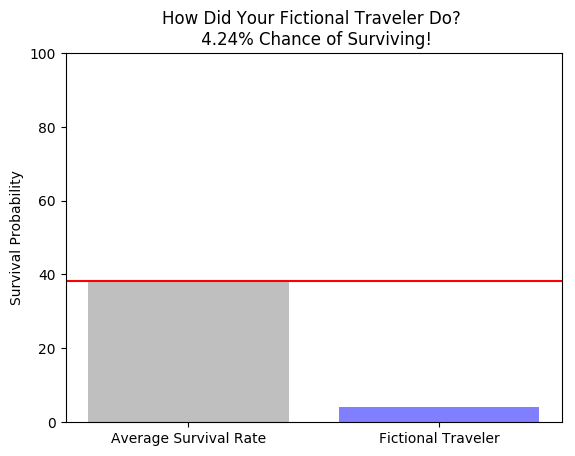

In [17]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
objects = ('Average Survival Rate', 'Fictional Traveler')
y_pos = np.arange(len(objects))
performance = [average_survival_rate, probability_of_surviving_fictional_character]
 
ax = fig.add_subplot(111)
colors = ['gray', 'blue']
plt.bar(y_pos, performance, align='center', color = colors, alpha=0.5)
plt.xticks(y_pos, objects)
plt.axhline(average_survival_rate, color="r")
plt.ylim([0,100])
plt.ylabel('Survival Probability')
plt.title('How Did Your Fictional Traveler Do? \n ' + str(round(probability_of_surviving_fictional_character,2)) + '% Chance of Surviving!')
 
plt.show()